# Is Warren Buffet's Portfolio Choice Optimal?

## 1. Introduction

Warren Buffet is the world's most prominent value investor. We decided to analyze his portfolio to see if there were any improvements to be made. We loosely make use of the work of:
- Michael Pinelis and David Ruppert (Machine learning portfolio allocation(2021))
-  Shihao Gu, Bryan Kelly, and Dacheng Xiu (Empirical Asset Pricing via Machine
 Learning(2019))

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import base64
from IPython.display import Image, display
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import cvxpy as cp
from sklearn.model_selection import GridSearchCV

(CVXPY) Aug 10 02:13:16 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 10 02:13:16 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
BuffetPortfolioOverview = pd.read_csv("Warren Buffet Portfolio Overview.csv")
BuffetPortfolioOverview

,Company,Ticker,"Market value as of 31 March, 2024",Number of shares,% of total portfolio
0,APPLE INC (COM),AAPL,"135,360,902,000","789,368,450",40.81%
1,BANK OF AMERICA CORP (COM),BAC,"39,165,748,000","1,032,852,006",11.81%
2,AMERICAN EXPRESS CO (COM),AXP,"34,520,240,000","151,610,700",10.41%
3,COCA COLA CO (COM),KO,"24,472,000,000","400,000,000",7.38%
4,CHEVRON CORP (COM),CVX,"19,398,898,000","122,980,207",5.85%
5,OCCIDENTAL PETROLEUM (COM),OXY,"16,118,698,000","248,018,128",4.86%
6,KRAFT HEINZ CO (COM),KHC,"12,015,925,000","325,634,818",3.62%
7,MOODYS CORP (COM),MCO,"9,695,962,000","24,669,778",2.92%
8,CHUBB LIMITED (COM),CB,"6,717,645,000","25,923,840",2.03%
9,DAVITA HEALTHCARE PARTNERS (COM),DVA,"4,982,993,000","36,095,570",1.50%


## 2. Research Method

The image below provides an overview of how we plan to proceed with our analysis.

In [3]:
def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    subgraph "Data Processing"
        A[Raw Data] --> B[Missing Value Imputation]
        B --> C[Normalization]
    end

    subgraph "Feature Engineering"
        D[Features] --> E[Fundamental Features]
        D --> F[Technical Features]
        D --> G[Sentiment Features]
    end
    
    E --> H[RF Model Training]
    F --> H
    G --> H
		
    subgraph "Training"
        H[RF Model Training] --> I[Hyperparameter Optimization]
        I --> J[Optimal Model]
    end

    subgraph "Prediction"
        K[Test Data] --> L[Return Ratio Prediction]
    end

    subgraph "Investment Strategy"
        M[Investment Strategy] --> N[Stock Selection]
        N --> O[Investment Portfolio Return & Std]
    end

    subgraph "Evaluation"
        P[Evaluation Method] --> Q[Sharpe Ratio]
    end

    C --> D
    J --> L
    L --> N
    O --> Q
""")

## 3. Data Processing

In [4]:
financial_ratios = pd.read_csv("2014-2024 Buffet Portfolio - financial ratios.csv")
financial_ratios.describe()

,gvkey,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,...,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing
count,4711.000000,4711.000000,4642.000000,4397.000000,4701.000000,4640.000000,4640.000000,4640.000000,4640.000000,4701.000000,...,4521.000000,4696.000000,4375.000000,2479.000000,4701.000000,4701.000000,4701.000000,4680.000000,4397.000000,3051.000000
mean,40526.249629,52176.914031,29.878632,0.603942,12.443296,12.870193,13.309260,16.051649,17.033933,3.696466,...,8.888087,1.292531,3.418766,14.165560,0.015078,0.020006,0.071173,-0.041818,5.523823,1.640502
std,58402.993987,29634.292265,137.151234,0.508289,127.622422,53.446141,53.375605,82.607543,82.795749,6.762963,...,12.296629,2.200181,9.041726,43.464448,0.044623,0.028905,0.124070,0.058970,9.266644,5.971164
min,1447.000000,11308.000000,-2615.300000,0.003000,-4544.900000,-714.520000,-714.520000,-2125.000000,-2125.000000,0.062000,...,-0.233000,0.113000,0.120000,-172.250000,0.000000,0.000000,0.000000,-0.267000,0.222000,-77.522000
25%,6239.000000,16678.000000,11.699750,0.199000,9.098000,9.100500,9.259250,8.402750,8.348750,1.190000,...,1.741000,0.383000,0.672500,2.986500,0.000000,0.000000,0.000000,-0.071000,1.076000,0.188000
50%,12459.000000,56223.000000,20.942000,0.466000,12.573000,15.622500,15.936000,16.173500,15.949500,1.888000,...,4.070000,0.715000,1.396000,6.415000,0.000000,0.006000,0.000000,-0.036000,2.175000,0.616000
75%,61483.000000,81055.000000,35.358500,0.928000,17.987000,24.894000,25.753750,27.509250,27.724250,3.906000,...,10.905000,1.235250,2.573000,12.497000,0.004000,0.032000,0.148000,-0.012000,5.232000,1.449000
max,339965.000000,92611.000000,1447.000000,3.614000,1223.880000,478.000000,490.500000,758.328000,774.000000,126.556000,...,77.108000,44.562000,152.413000,977.032000,0.465000,0.204000,0.905000,0.757000,64.657000,63.498000


In [5]:
stock = pd.read_csv("2014-2024 Buffet Portfolio - stock.csv")
stock.describe()

/tmp/ipykernel_67658/244833115.py:1: DtypeWarning: Columns (5,9,22,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  stock = pd.read_csv("2014-2024 Buffet Portfolio - stock.csv")


,PERMNO,SHRCD,EXCHCD,NAICS,PERMCO,ISSUNO,HEXCD,HSICCD,DLAMT,DLSTCD,...,SHROUT,CFACPR,CFACSHR,OPENPRC,NUMTRD,vwretd,vwretx,ewretd,ewretx,sprtrn
count,89589.000000,89589.000000,89589.000000,89563.000000,89589.000000,89589.000000,89589.000000,89589.000000,44.000000,44.000000,...,8.958300e+04,89583.000000,89583.000000,89583.000000,2.639500e+04,89589.000000,89589.000000,89589.000000,89589.000000,89589.000000
mean,49773.033832,15.129893,1.757973,464534.521733,29650.113954,16938.273159,1.801505,5891.083269,6.538636,115.250000,...,1.314680e+06,1.576633,1.546429,227.541278,7.267247e+04,0.000449,0.000371,0.000343,0.000261,0.000439
std,30343.528813,14.497378,1.053536,110869.404027,17500.224502,29921.136917,1.062598,2302.737062,23.420962,43.099736,...,2.443694e+06,3.051686,3.055253,635.758014,1.557989e+05,0.011025,0.011024,0.010709,0.010710,0.011170
min,11308.000000,11.000000,1.000000,211111.000000,7.000000,0.000000,1.000000,1311.000000,0.000000,100.000000,...,3.179000e+03,0.904200,0.250000,3.050000,0.000000e+00,-0.118168,-0.118218,-0.107631,-0.107768,-0.119841
25%,15998.000000,11.000000,1.000000,423990.000000,20440.000000,0.000000,1.000000,4832.000000,0.000000,100.000000,...,1.845000e+05,1.000000,1.000000,37.475000,7.672000e+03,-0.003923,-0.003978,-0.004576,-0.004659,-0.003812
50%,56223.000000,11.000000,1.000000,517210.000000,21299.000000,0.000000,1.000000,6029.000000,0.000000,100.000000,...,4.387400e+05,1.000000,1.000000,76.660000,2.055000e+04,0.000668,0.000550,0.000709,0.000623,0.000597
75%,80924.000000,11.000000,3.000000,524130.000000,50700.000000,20733.000000,3.000000,7370.000000,0.000000,100.000000,...,1.045085e+06,1.000000,1.000000,163.519995,5.295650e+04,0.005631,0.005565,0.005748,0.005679,0.005690
max,92611.000000,73.000000,4.000000,721110.000000,59045.000000,89707.000000,4.000000,9999.000000,128.769990,241.000000,...,1.710254e+07,28.000000,28.000000,7028.500000,2.970000e+06,0.091556,0.091477,0.082175,0.082032,0.093828


Merged data was created with the combination of the financial ratios, stock ratios and a few macroeconomic predictors as indicated by Gu et al. Here we simply present the cleaned data as the merge process was lengthy, and laborious.

In [6]:
merged_data = pd.read_csv("merged_financial_stock_macro_data.csv")
merged_data = merged_data.drop(merged_data.columns[0], axis=1)
merged_data.head()

,TICKER,date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,...,TICKER_encoded,SHRCD_encoded,EXCHCD_encoded,SICCD_encoded,market_cap,RET_calc,RET_interp,TB3MS,T10Y2Y,BAA10Y
0,AAPL,2014-01-31,17.588,0.327,7.993,12.506,12.594,12.594,12.594,2.613,...,0.0,0.0,1.0,10.0,4.465297e+08,0.001637,0.001637,0.04,2.464286,2.334762
1,AAPL,2014-02-28,18.776,0.296,7.764,0.463,0.466,0.466,0.466,2.698,...,0.0,0.0,1.0,10.0,4.694003e+08,-0.002710,-0.002710,0.05,2.382632,2.390000
2,AAPL,2014-03-31,18.501,0.296,7.764,0.472,0.475,0.475,0.475,2.658,...,0.0,0.0,1.0,10.0,4.625330e+08,-0.000224,-0.000224,0.05,2.324286,2.340952
3,AAPL,2014-04-30,20.332,0.296,7.764,0.519,0.523,0.523,0.523,2.921,...,0.0,0.0,1.0,10.0,5.082923e+08,-0.003782,-0.003782,0.03,2.288095,2.199048
4,AAPL,2014-05-31,20.513,0.302,7.873,0.537,0.540,0.540,0.540,3.097,...,0.0,0.0,1.0,10.0,5.452542e+08,-0.003746,-0.003746,0.03,2.170000,2.203810


# 4. Descriptive Analysis

In this section we explore various features of our data set. We can see that price is highly variable over time. In the correlation matrix we see that the price ratios related to shareholder dividends, income and operating expenses were the most highly correlated. For the most part, stock market returns were 0 and most companies had a negligible market size.

/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


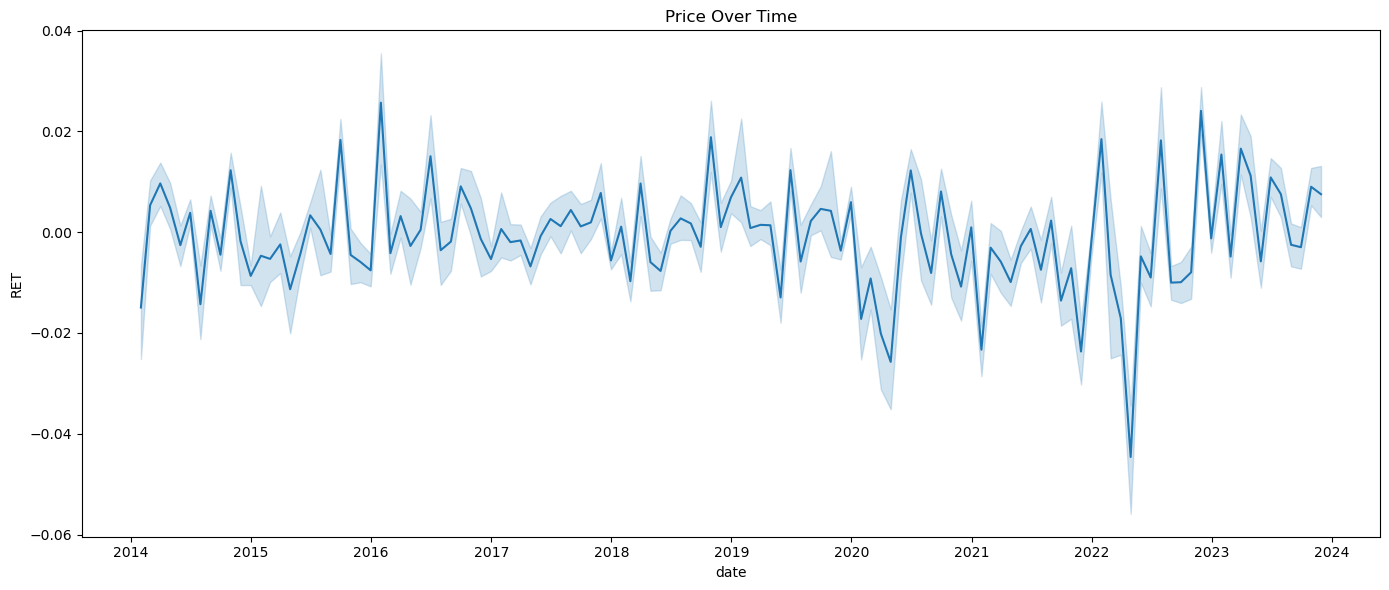

In [7]:
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Basic statistical description
statistical_description = merged_data.describe()

# Plotting the trends of a few selected metrics over time
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Plotting RET
sns.lineplot(x='date', y='RET', data=merged_data).set_title('Price Over Time')

plt.tight_layout()
plt.show()

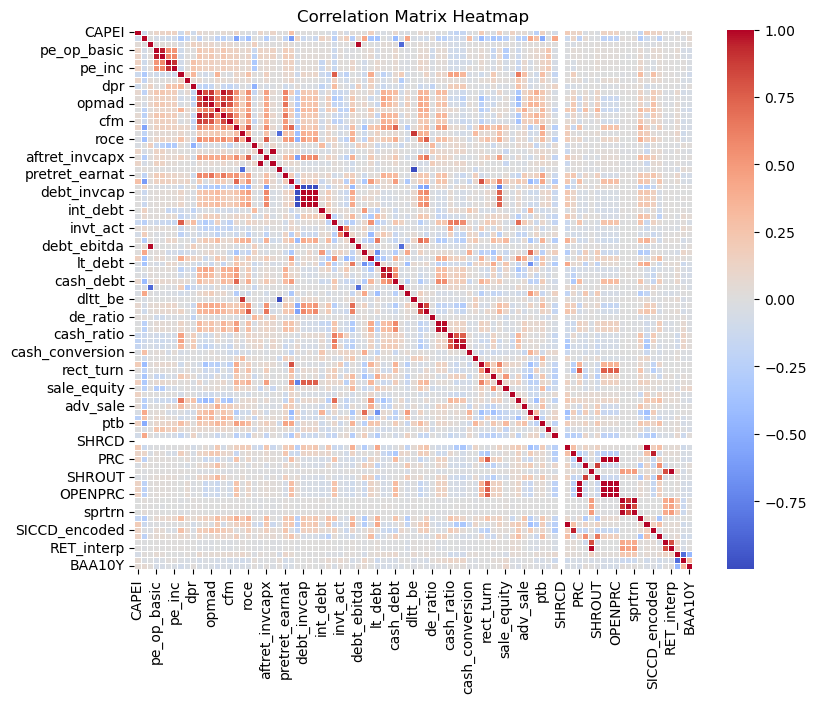

<Figure size 640x480 with 0 Axes>

In [8]:
# Recalculate the correlation matrix
correlation_matrix = merged_data.select_dtypes(include=['number']).drop(columns = 'SHRCD_encoded').corr()

# Set up the matplotlib figure
plt.figure(figsize=(9, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=False, fmt=".1f", linewidths=.5, cmap="coolwarm")
plt.title('Correlation Matrix Heatmap')
plt.show()
plt.savefig('Correlation_matrix_heatmap.png')


/tmp/ipykernel_67658/980479959.py:12: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  numeric_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax)


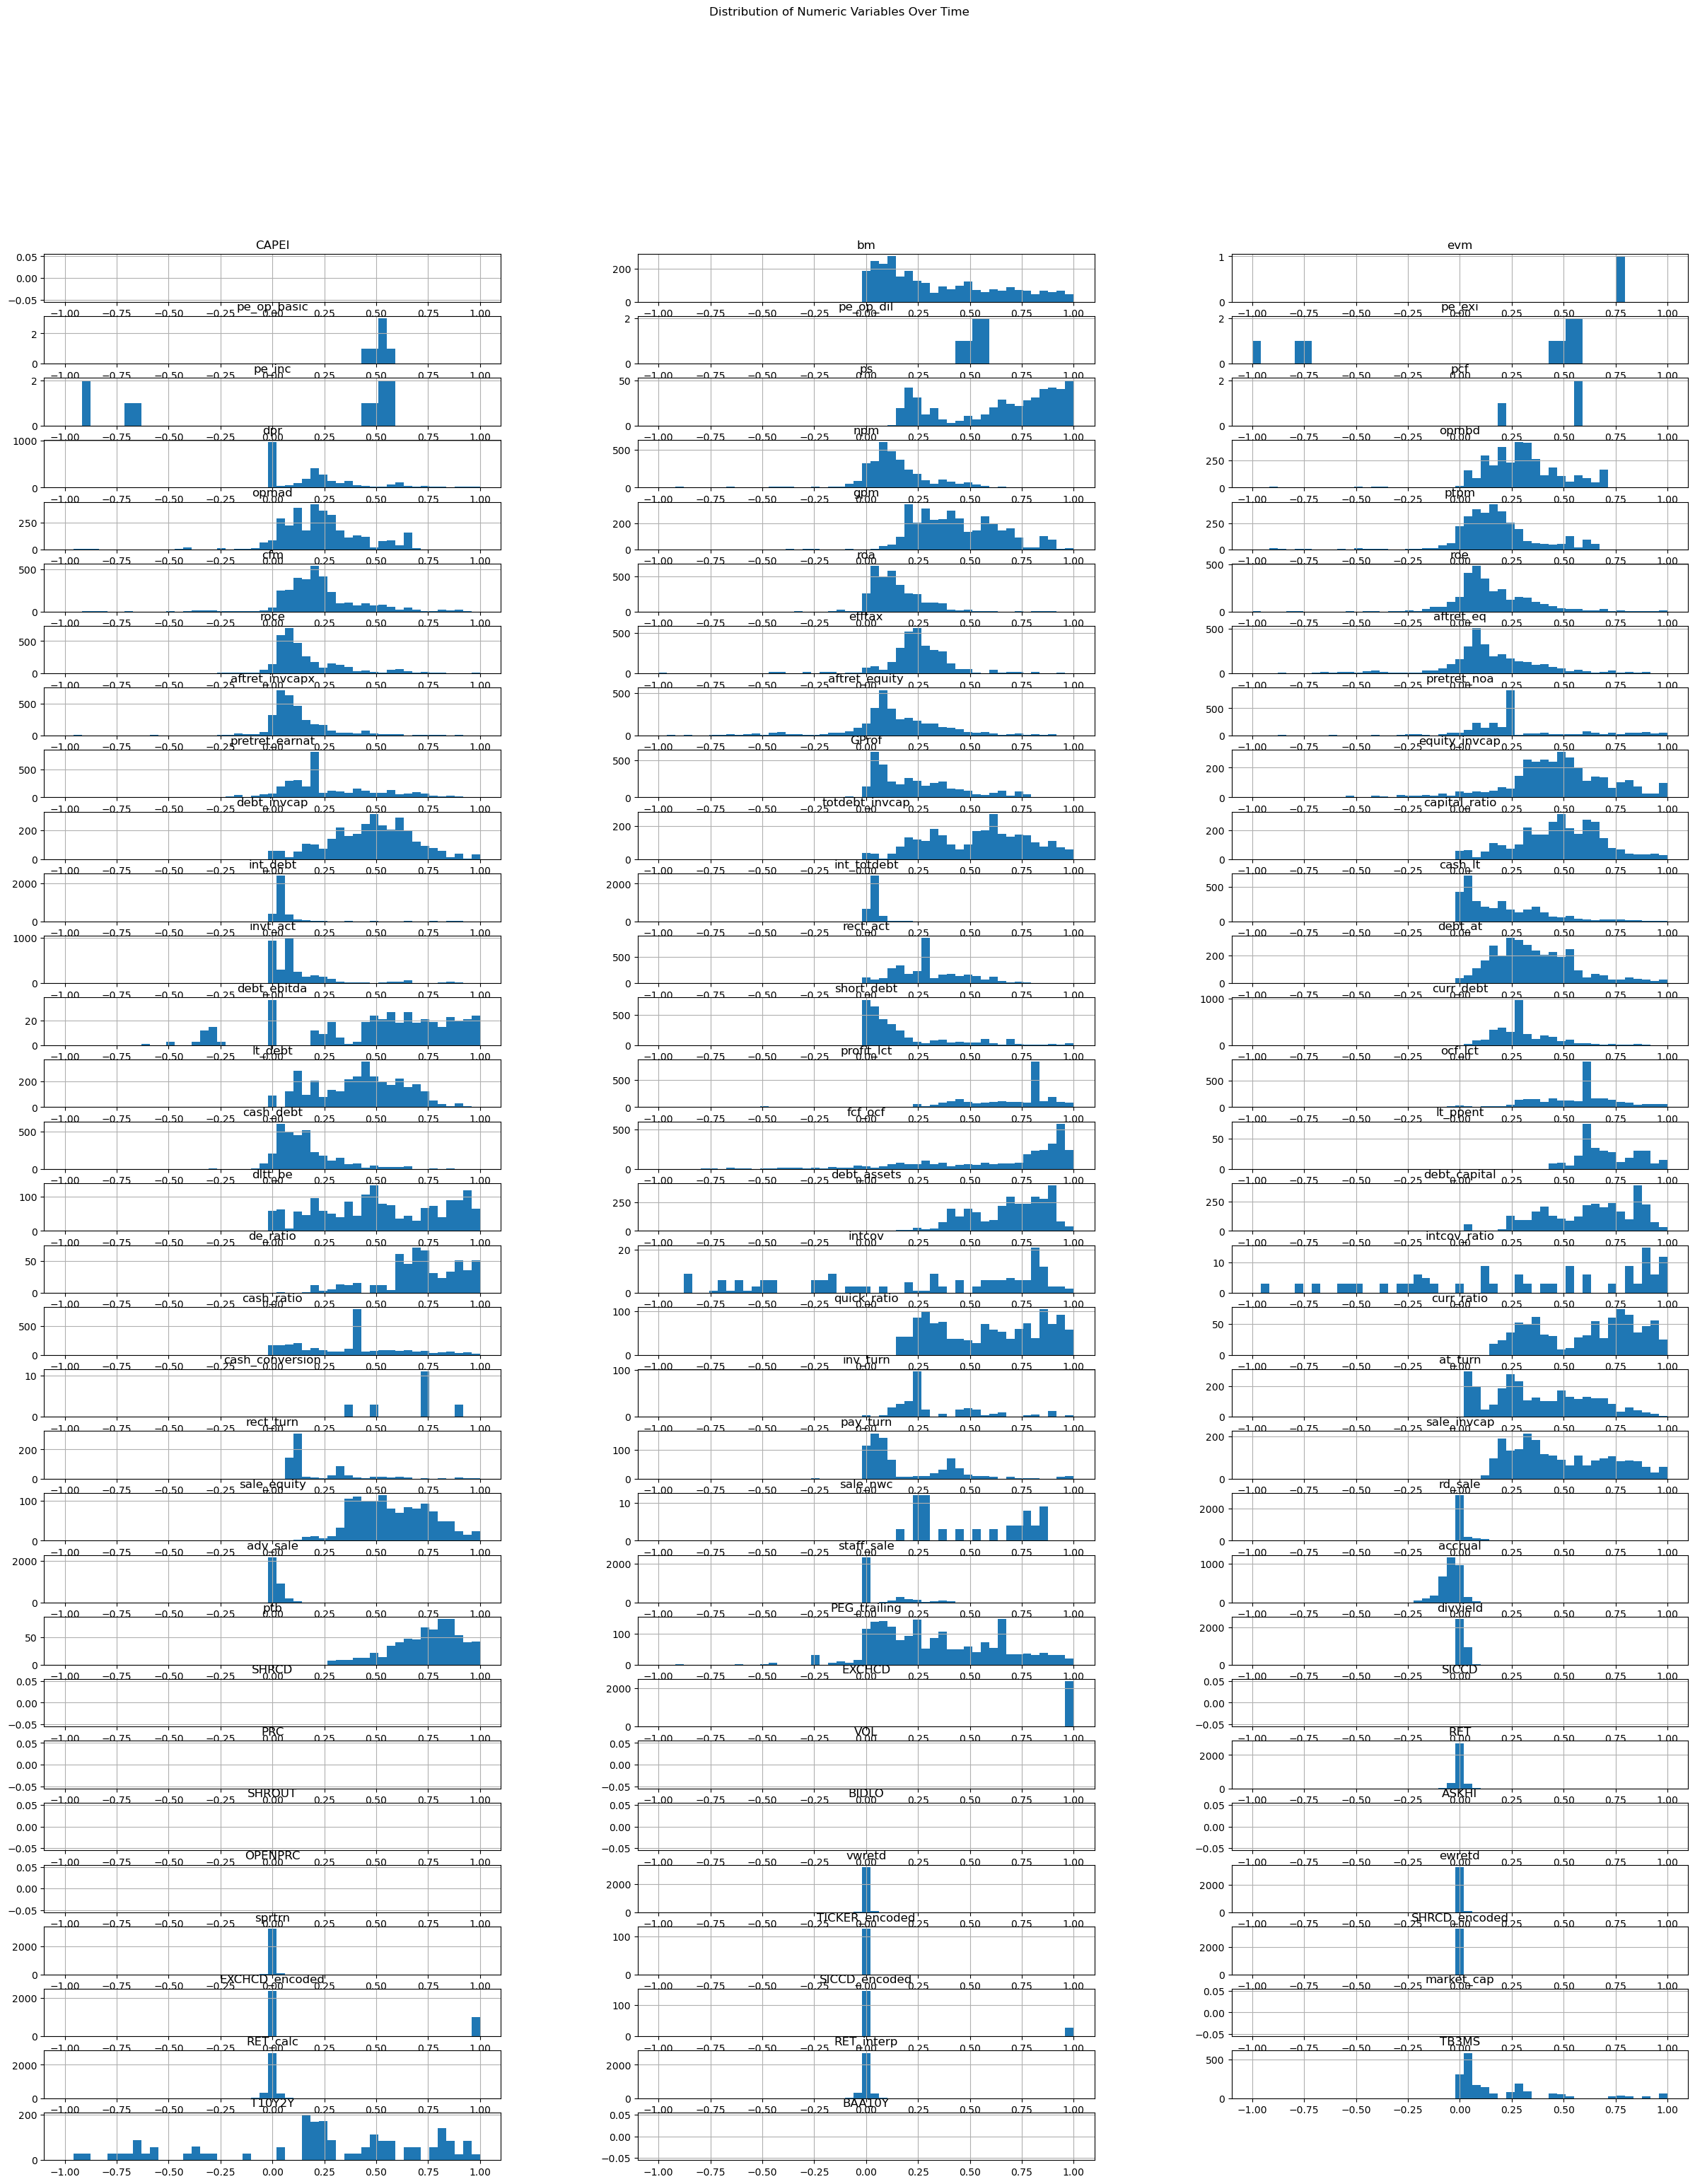

In [9]:
# Filter out non-numeric columns from merged_data
numeric_data = merged_data.select_dtypes(include=[np.number])

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the figure height and width
fig.set_figheight(35)
fig.set_figwidth(30)

# Plot histograms for the numeric columns in numeric_data
numeric_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax)

# Set the title for the figure
fig.suptitle('Distribution of Numeric Variables Over Time')

# Save the figure as 'numbers_over_time.png'
plt.savefig('Distribution_of_Numeric_Variables_Over_Time.png')

/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


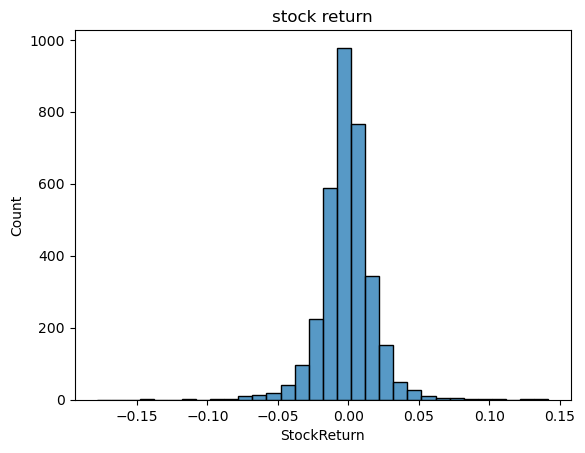

In [10]:
df_3 = merged_data[["RET"]]
df_3 = df_3.rename(columns={'RET': 'StockReturn'})
sns.histplot(data = df_3, x ="StockReturn", binwidth = 0.01, binrange = (df_3["StockReturn"].min()+ 0.00000000001, df_3["StockReturn"].max()- 0.01))
plt.title('stock return')
plt.show()

/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


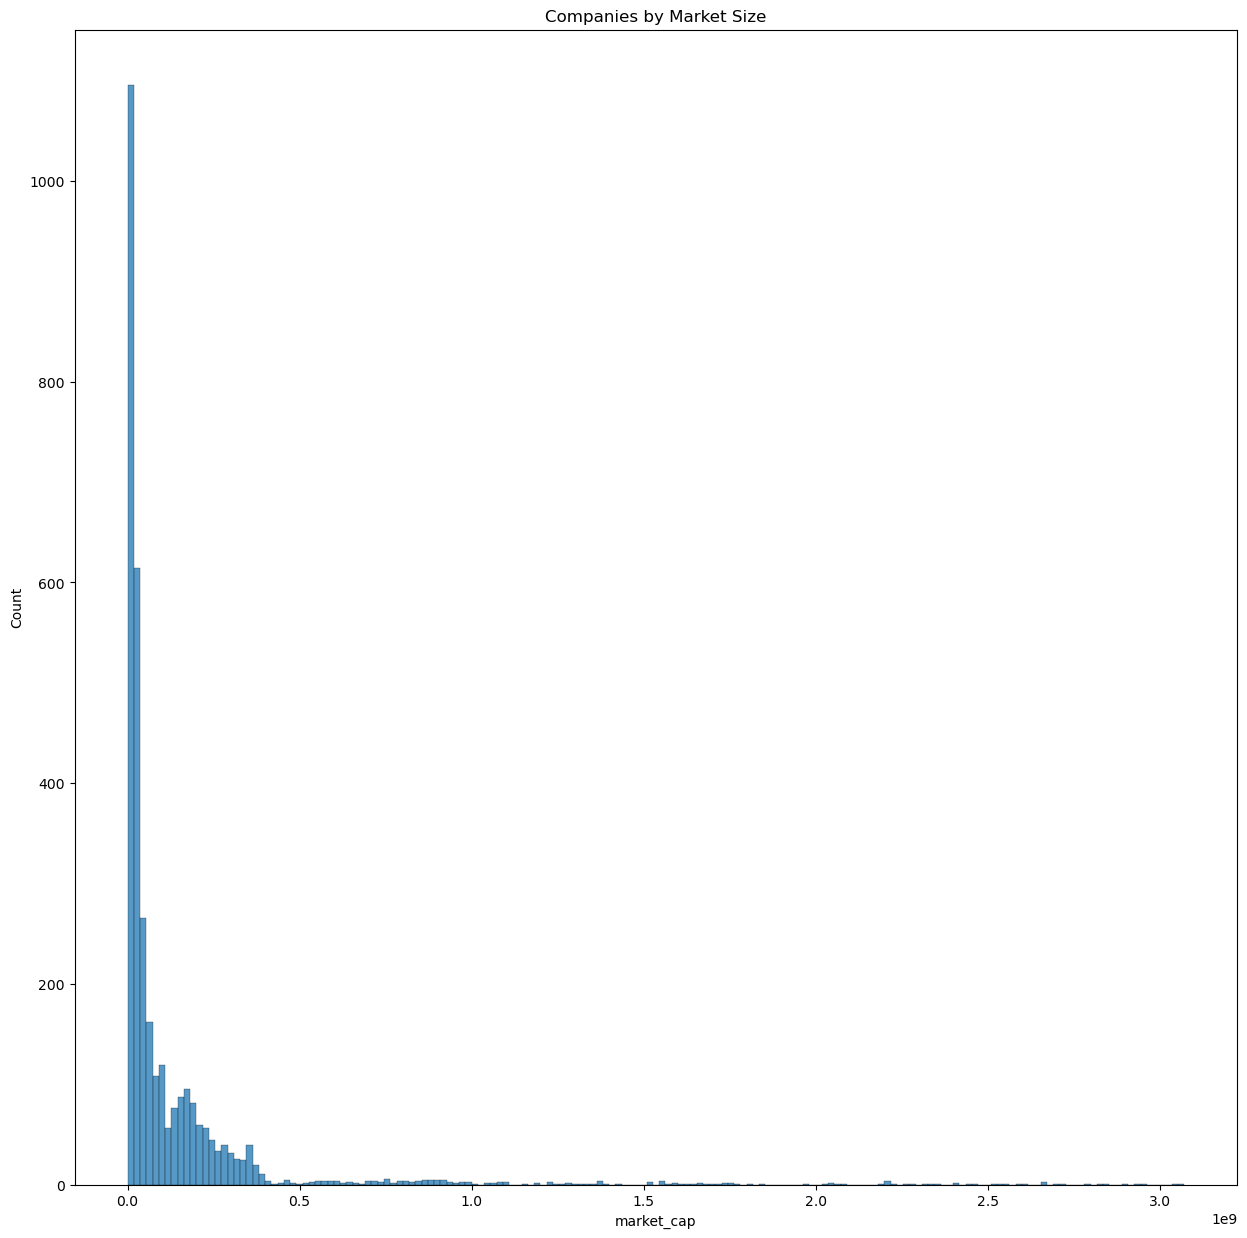

In [11]:
# Set the global size of the figure
fig, ax = plt.subplots()

# Calculate the maximum market capitalization
max_size = merged_data['market_cap'].max()

# Plot the histogram
ax = sns.histplot(data=merged_data, x="market_cap", binrange=(0, max_size))
ax.set_title('Companies by Market Size')  # Set the title

# Define the image size
fig.set_figheight(15)
fig.set_figwidth(15)

# Show the figure
plt.show()

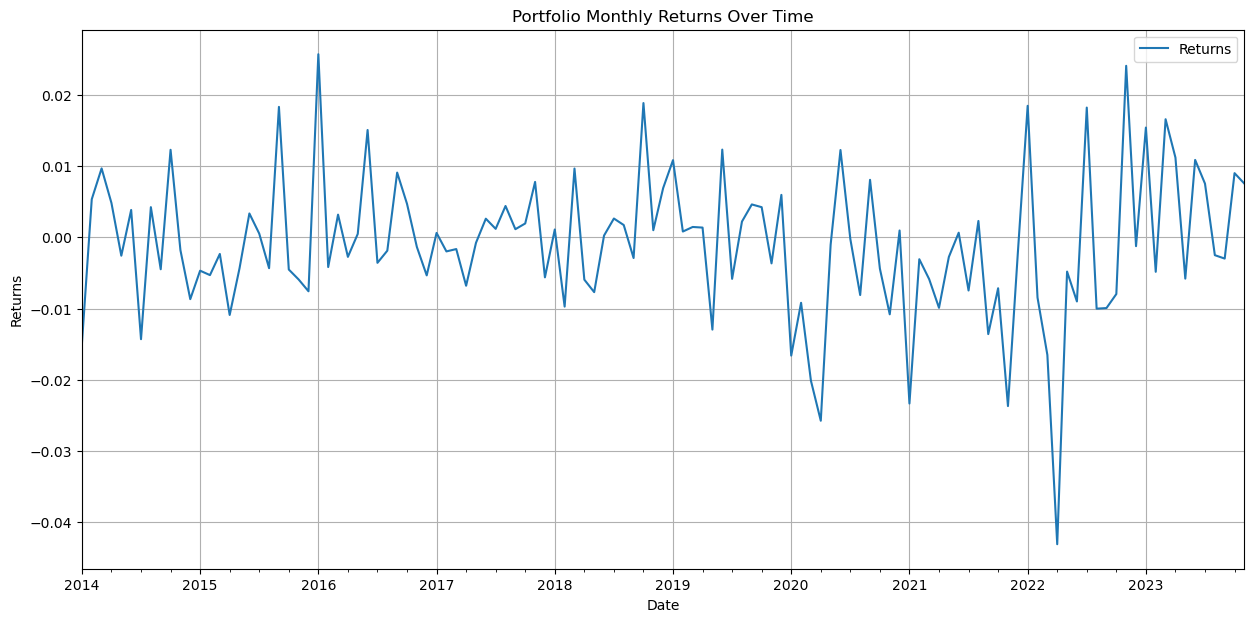

In [12]:
# Assuming final_data is defined
ret_data = merged_data[["RET", "TICKER", "date"]].copy()  # Create a copy to work on to avoid affecting original data

# Create equal weights safely using loc
ret_data['eq_weights'] = 1 / ret_data.groupby('date')['TICKER'].transform('size')

# Calculate monthly return of the equally weighted portfolio containing all stocks
# Use loc to ensure the operation is directly on the DataFrame
ret_data.loc[:, 'return_stock_ew'] = ret_data['RET'].astype(float) * ret_data['eq_weights']

# Calculate the total returns for each date
ret_data.loc[:, 'Returns'] = ret_data.groupby('date')['return_stock_ew'].transform('sum')

# Drop duplicates and set index
unique_ret_data = ret_data[['date', 'Returns']].drop_duplicates().set_index('date')

# Plot the portfolio returns over time
unique_ret_data.plot(grid=True, figsize=(15, 7))
plt.title('Portfolio Monthly Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)

# Save the graph
plt.show()

# 5. Feature Engineering

Our feature engineering is relatively simple the associated comments describe how we proceeded.

In [13]:
merged_data.columns

Index(['TICKER', 'date', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil',
       'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm',
       'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
       'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
       'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
       'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent',
       'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
       'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio',
       'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn',
       'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale',
       'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield', 'COMNAM',
       'SHRCD', 'EXCHCD', 'SICCD', 'PRC', 'VOL', 'RET

In [14]:
# Load your historical stock data
featureDf = merged_data.copy()
featureDf['RET'] = featureDf['RET'].pct_change()

# Drop NaN values
featureDf = featureDf.dropna()

# Define the rolling window sizes
monthly_lag = 1
annual_lag = 6

# Lag monthly features by one month
monthly_features = ['CAPEI', 'TB3MS', 'T10Y2Y', 'BAA10Y']
for feature in monthly_features:
    featureDf[f'{feature}_lag'] = featureDf[feature].shift(monthly_lag)

# Lag annual features by six months
annual_features = ['bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 
                   'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 
                   'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap', 
                   'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 
                   'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 
                   'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 
                   'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 
                   'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 
                   'ptb', 'PEG_trailing', 'divyield', 'market_cap']

for feature in annual_features:
    featureDf[f'{feature}_lag'] = featureDf[feature].shift(annual_lag)

# Drop NaN values created by lagging
featureDf = featureDf.dropna()

# Features and target
X = featureDf[['RET'] + [f'{feature}_lag' for feature in monthly_features + annual_features]]
y = featureDf['RET']

# Normalize the features
X = (X - X.mean()) / X.std()

/tmp/ipykernel_67658/2930111544.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  featureDf['RET'] = featureDf['RET'].pct_change()
/home/onlyartist9/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


# 6. Prescriptive Analysis

According to Gu and Pineli et al, the best models for asset pricing and portfolio optimization seem to be Random Forests, Neural Networks and Gradient Boosted trees. For lack of time and compute intensity we focus on Random Forests and Gradient Boosted Trees.

In [15]:
# Assuming merged_data is your DataFrame
# Define the independent variables (X) and the dependent variable (y)
features = merged_data.columns[~merged_data.columns.isin(['TICKER', 'RET', 'date', 'RET_interp', 'RET_calc'])].tolist()
X = merged_data[features]
y = merged_data['RET']

# Drop rows where the target variable y is NaN
X = X[~y.isna()]
y = y.dropna()

# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = [col for col in X.columns if col not in categorical_features]

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute NaN values with the mean
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute NaN values with the most frequent value
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Apply the preprocessing steps
X_preprocessed = preprocessor.fit_transform(X)

# Get feature names after preprocessing
num_features = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numerical_features)
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = list(num_features) + list(cat_features)

# Convert the preprocessed data back to a DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_df, y, test_size=0.2, random_state=42)

print("Preprocessed feature names:\n", feature_names)

Preprocessed feature names:
 ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield', 'SHRCD', 'EXCHCD', 'SICCD', 'PRC', 'VOL', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'vwretd', 'ewretd', 'sprtrn', 'TICKER_encoded', 'SHRCD_encode

## Random Forest

In [16]:
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
print(f'Random Forest Out-of-sample R^2: {rf_r2}')
print(f'Random Forest Mean Squared Error: {rf_mse}')

# Feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Extract the top 20 features
top_20_indices = indices[:20]
top_20_features = X_train.columns[top_20_indices]

# Print the top 20 feature ranking
print("Top 20 Feature ranking:")
for i, feature in enumerate(top_20_features):
    print(f"{i + 1}. feature {feature} ({importances[top_20_indices[i]]})")

# Select the top 20 features
X_top_20 = X_preprocessed_df[top_20_features]

# Split the data into training and testing sets
X_train_top_20, X_test_top_20, y_train, y_test = train_test_split(X_top_20, y, test_size=0.2, random_state=42)

Random Forest Out-of-sample R^2: 0.1910458950465742
Random Forest Mean Squared Error: 0.00030788516905850703
Top 20 Feature ranking:
1. feature vwretd (0.1639402749850967)
2. feature sprtrn (0.0940426250386985)
3. feature ewretd (0.04728066343103504)
4. feature VOL (0.043585137820118885)
5. feature CAPEI (0.02616626149877511)
6. feature market_cap (0.020439647900859042)
7. feature sale_nwc (0.018634469716643474)
8. feature pe_op_basic (0.016894479626946374)
9. feature curr_debt (0.01421042938068513)
10. feature pe_op_dil (0.013904633624369634)
11. feature BAA10Y (0.013316871032556233)
12. feature ocf_lct (0.012832629930959034)
13. feature accrual (0.01220521702222583)
14. feature evm (0.011985938215210141)
15. feature ps (0.011544747587962796)
16. feature efftax (0.011310738304132269)
17. feature pay_turn (0.011147094091905983)
18. feature divyield (0.01102476926626882)
19. feature ptb (0.01047923701216509)
20. feature rect_act (0.010445745491547604)


## XGBoost

In [17]:
# Select the top 20 features
X_top_20 = X_preprocessed_df[top_20_features]

# Split the data into training and testing sets
X_train_top_20, X_test_top_20, y_train, y_test = train_test_split(X_top_20, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_top_20, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the XGBoost model with best parameters
xgb_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_top_20, y_train)

# Predict and evaluate
xgb_pred = xgb_model.predict(X_test_top_20)
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mse = mean_squared_error(y_test, xgb_pred)
print(f'XGBoost Out-of-sample R^2: {xgb_r2}')
print(f'XGBoost Mean Squared Error: {xgb_mse}')

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}
XGBoost Out-of-sample R^2: 0.25222801540472684
XGBoost Mean Squared Error: 0.00028459946304071966


# 7. Prescriptive Analysis

For our portfolio optimization we use cvxpy and mean variance optimization assuming risk neutrality. It must be said that the portfolio gains different values based on our personal risk preference.

In [18]:
# Convex optimization using the predicted weights
def convex_optimization(expected_returns, cov_matrix):
    n = len(expected_returns)
    weights = cp.Variable(n)
    portfolio_return = expected_returns @ weights
    portfolio_risk = cp.quad_form(weights, cov_matrix)
    objective = cp.Maximize(portfolio_return - risk_tolerance * portfolio_risk)
    constraints = [cp.sum(weights) == 1, weights >= 0]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return weights.value, objective.value

# Use predicted returns from the XGBoost model
expected_returns = xgb_pred[:20]
cov_matrix = np.cov(X_test_top_20.T)[:20, :20]
risk_tolerance = 0

# Optimize portfolio
shares, objective_value = convex_optimization(expected_returns, cov_matrix)
print(f'Optimized Normalized Portfolio Shares: {shares}')
print(f'Portfolio Return: {objective_value}')

Optimized Normalized Portfolio Shares: [ 2.95687254e-28  2.95801269e-28  2.95869062e-28  2.22044901e-22
  2.95471550e-28  2.95841328e-28  2.96016973e-28  1.00000000e+00
  2.95539343e-28  2.95878306e-28  2.96020055e-28  2.96087847e-28
  2.95748884e-28  2.95887551e-28  2.95385268e-28  2.95480794e-28
  2.96109418e-28  2.95902958e-28  2.95514691e-28 -2.22044308e-22]
Portfolio Return: 0.01903193444013596


# 8. Assessment

In [19]:
# Create a new DataFrame for the portfolio
tickers = merged_data['TICKER'].unique()[:20]
portfolio_df = pd.DataFrame({
    'Ticker': tickers,
    'Share': shares
})

print("Portfolio and corresponding weights: \n")
portfolio_df = portfolio_df.sort_values(by='Share', ascending=False)
print(portfolio_df)

print("Buffet's portfolio \n")
print(BuffetPortfolioOverview)

Portfolio and corresponding weights: 

   Ticker         Share
7      CB  1.000000e+00
3     AXP  2.220449e-22
16    ITG  2.961094e-28
11    CVX  2.960878e-28
10    COF  2.960201e-28
6       C  2.960170e-28
17    JEF  2.959030e-28
13     ES  2.958876e-28
9    CHTR  2.958783e-28
2    AMZN  2.958691e-28
5     BYI  2.958413e-28
1    ALLY  2.958013e-28
12    DVA  2.957489e-28
0    AAPL  2.956873e-28
8     CBS  2.955393e-28
18    KHC  2.955147e-28
15  FWONK  2.954808e-28
4     BAC  2.954715e-28
14    FND  2.953853e-28
19     KO -2.220443e-22
Buffet's portfolio 

                                            Company Ticker  \
0                                APPLE INC    (COM)   AAPL   
1                     BANK OF AMERICA CORP    (COM)    BAC   
2                      AMERICAN EXPRESS CO    (COM)    AXP   
3                             COCA COLA CO    (COM)     KO   
4                             CHEVRON CORP    (COM)    CVX   
5                     OCCIDENTAL PETROLEUM    (COM)    OXY   
6 

In [23]:
y.isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
3347    False
3348    False
3349    False
3350    False
3351    False
Name: RET, Length: 3345, dtype: bool

In [24]:
risk_free_rate = merged_data['TB3MS'].median() 

returns = pd.Series(expected_returns) 

# Define the rolling window size
window_size = 12  # For example, 12 months

# Calculate the rolling Sharpe Ratio
rolling_sharpe = returns.rolling(window=window_size).apply(lambda x: (x.mean() - risk_free_rate) / x.std(), raw=True)

# Calculate the average Sharpe Ratio
average_sharpe = rolling_sharpe.mean()
print("Average Sharpe Ratio: ", average_sharpe)

# Calculate the cumulative average Sharpe Ratio
cumulative_average_sharpe = rolling_sharpe.expanding().mean()
print("Cumulative Average Sharpe Ratio: ", cumulative_average_sharpe)

# Calculate the standard deviation of returns
std_dev = np.std(expected_returns)

# Calculate the Sharpe Ratio for the entire period
sharpe_ratio = (objective_value - risk_free_rate) / std_dev
print(f"Sharpe Ratio: {sharpe_ratio}")


Average Sharpe Ratio:  -74.42532668071378
Cumulative Average Sharpe Ratio:  0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11   -75.684377
12   -75.720663
13   -75.596447
14   -74.945102
15   -74.503843
16   -73.820098
17   -73.283847
18   -73.010152
19   -74.425327
dtype: float64
Sharpe Ratio: -72.4838808915425


Our optimized portfolio while begetting us slightly positive returns does still underperform the risk free alternatives by quite a bit. Given the sizeable investment in Apple our portfolio suggests Buffet divest a significant share of his Apple assets.

In May of this year we saw Buffet divest 13% of his share in Apple before its Buyback so perhaps our model is on to something.